### Урок 4. Семантическая сегментация

In [1]:
# Датасет скачан. API собрано. Начнем процесс
import os
import sys
from pycocotools.coco import COCO
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Input, Activation, concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
COCO_ROOT = './dataset/'

In [4]:
class Dataset():
    
    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        
        img = tf.pad(img, pad)
        
        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else:
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]
        
        return img
    
    def train_dataset(self, batch_size, epochs=0, inp_size=256):
        
        def item_to_images(item, random_crop=True):
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)
            img = tf.cast(img_combined[..., :3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[..., 3:4], tf.float32)
            return img, mask_class
        
        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        if self.max_samples > 0:
            dataset = dataset.take(self.max_samples)
        dataset = dataset.map(item_to_images)
        if epochs > 0:
            dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        
        return dataset
    
    def val_dataset(self, batch_size, inp_size):
        
        def item_to_images(item, random_crop=True):
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)
            img = tf.cast(img_combined[..., :3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[..., 3:4], tf.float32)
            return img, mask_class
        
        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        if self.max_samples > 0:
            dataset = dataset.take(self.max_samples)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        
        return dataset
    

In [5]:
class COCO_Dataset(Dataset):
    
    def __init__(self, sublist, topic='person', max_samples=0):
        ann_file_fpath = os.path.join(COCO_ROOT, 
                                      'annotations', 
                                      'instances_' + sublist + 
                                      '2017.json')
        
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=[topic])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)
        self.max_samples = max_samples
        
    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])
        
        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))
            
        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)
        
        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)
        
        return img_combined

In [86]:
COCO_train_ds = COCO_Dataset('train')
COCO_val_ds = COCO_Dataset('val')

loading annotations into memory...
Done (t=11.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [59]:
train_ds = COCO_train_ds.train_dataset(32, 10, 256)

In [60]:
val_ds = COCO_val_ds.val_dataset(32, 256)

In [61]:
# Посмотрим, что там получилось вообще....
test_batch = iter(train_ds).next()

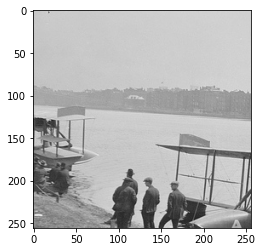

In [66]:
plt.imshow(test_batch[0][0].numpy())

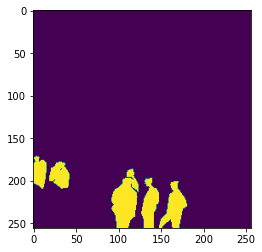

In [73]:
# И метки к ней
plt.imshow(test_batch[1][0].numpy())

In [74]:
# Отлично!
# Теперь строим модель

In [105]:
# Dice коэффициент (В качестве метрики нам понадобится что-то же :) знания почерпнутые из пред курсов
def dice_coef(y_true, y_pred):
    return (2.0 * K.sum(y_true * y_pred) + 1.0) / (K.sum(y_true) + K.sum(y_pred) + 1.0)

In [80]:
# Для начала, что-нибудь простенькое - чтобы понять вообще - это все работает или нет...
model = Sequential()
model.add(Input(shape=(256, 256, 3)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=[dice_coef])

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_6 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_7 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)     

In [82]:
history = model.fit(train_ds, validation_data=val_ds)

  929/20035 [>.............................] - ETA: 4:43:57 - loss: 0.0000e+00 - dice_coef: 0.3656

KeyboardInterrupt: 

In [83]:
# 5 часов - это запредельно... Слишком много там примеров видимо. Попробуем уменьшить

In [7]:
COCO_train_ds = COCO_Dataset('train', max_samples=1000)
COCO_val_ds = COCO_Dataset('val', max_samples=1000)

loading annotations into memory...
Done (t=11.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [8]:
train_ds = COCO_train_ds.train_dataset(batch_size=32, inp_size=256)

In [9]:
val_ds = COCO_val_ds.val_dataset(batch_size=32, inp_size=256)

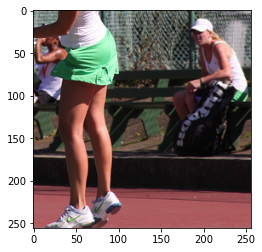

In [10]:
# Проверочка
test_batch = iter(train_ds).next()
plt.imshow(test_batch[0][0].numpy())

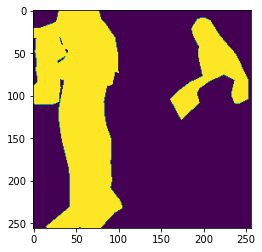

In [11]:
# Метка
plt.imshow(test_batch[1][0].numpy())

In [134]:
# Нууу... ок

In [12]:
model = Sequential()
model.add(Input(shape=(256, 256, 3)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=[dice_coef])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0

In [14]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
31/31 [==============================] - 34s 930ms/step - loss: 0.5457 - dice_coef: 0.2854 - val_loss: 0.6109 - val_dice_coef: 0.2943
Epoch 2/10
31/31 [==============================] - 29s 927ms/step - loss: 0.4823 - dice_coef: 0.3103 - val_loss: 0.5544 - val_dice_coef: 0.2714
Epoch 3/10
31/31 [==============================] - 28s 917ms/step - loss: 0.4753 - dice_coef: 0.3495 - val_loss: 0.5430 - val_dice_coef: 0.2627
Epoch 4/10
31/31 [==============================] - 28s 909ms/step - loss: 0.4795 - dice_coef: 0.3097 - val_loss: 0.5137 - val_dice_coef: 0.2552
Epoch 5/10
31/31 [==============================] - 27s 888ms/step - loss: 0.4675 - dice_coef: 0.3046 - val_loss: 0.5247 - val_dice_coef: 0.2166
Epoch 6/10
31/31 [==============================] - 29s 952ms/step - loss: 0.4702 - dice_coef: 0.3611 - val_loss: 0.5376 - val_dice_coef: 0.2040
Epoch 7/10
31/31 [==============================] - 26s 858ms/step - loss: 0.4824 - dice_coef: 0.3585 - val_loss: 0.5503 - val_dic

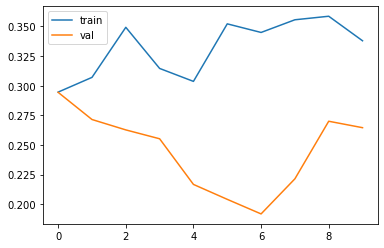

In [15]:
plt.plot(range(10), history.history['dice_coef'])
plt.plot(range(10), history.history['val_dice_coef'])
plt.legend(('train', 'val'))

In [16]:
# Лютая дичь какая-то )) Надо пробовать более серьезную архитектуру...

In [17]:
# Займемся U-Net. Берем пре-тренированную модель

In [18]:
inception = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

inception.trainable = False

In [19]:
inception.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 127, 127, 32) 96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 127, 127, 32) 0           batch_normalization_6[0][0]      
________________________________________________________________________________

In [20]:
from tensorflow.keras.utils import plot_model

In [21]:
plot_model(inception, to_file='inception.png')

In [22]:
# Эммм... что-то с Инсепшн я погорячился пожалуй )
# Что нибудь более простое.. 

In [23]:
vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

vgg.trainable = False

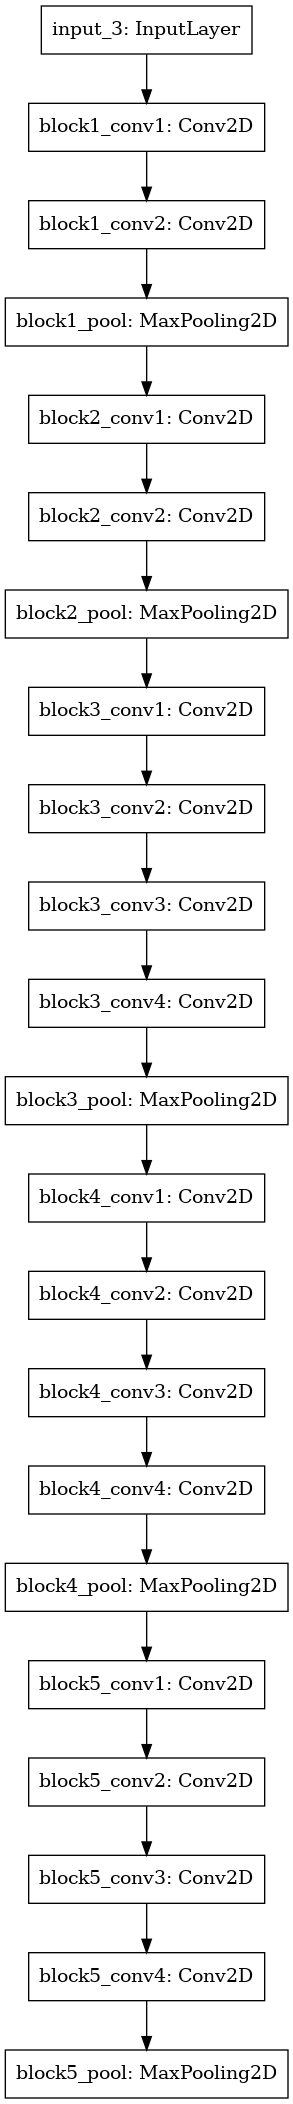

In [24]:
plot_model(vgg, to_file='vggn.png')

In [25]:
# Это куда более понятно )
# Её мы будем использовать в качестве "понижающего" плеча U-Net

In [26]:
for i, layer in enumerate(vgg.layers):
    print('{}: {}'.format(i, layer.name))

0: input_3
1: block1_conv1
2: block1_conv2
3: block1_pool
4: block2_conv1
5: block2_conv2
6: block2_pool
7: block3_conv1
8: block3_conv2
9: block3_conv3
10: block3_conv4
11: block3_pool
12: block4_conv1
13: block4_conv2
14: block4_conv3
15: block4_conv4
16: block4_pool
17: block5_conv1
18: block5_conv2
19: block5_conv3
20: block5_conv4
21: block5_pool


In [27]:
# Брать результаты из понижающего плеча мы должны со сверточных слоев перед пулингами. 
# Это слои 2, 5, 10, 15, 20..

In [28]:
def unet(shape=(256, 256, 3), num_classes=1):
    pre_trained_model = tf.keras.applications.VGG19(input_shape=shape, 
                                                    include_top=False, 
                                                    weights="imagenet")
    for layer in pre_trained_model.layers:
        layer.trainable = False
    
    block_out_1 = pre_trained_model.layers[2].output
    block_out_2 = pre_trained_model.layers[5].output
    block_out_3 = pre_trained_model.layers[10].output
    block_out_4 = pre_trained_model.layers[15].output
    block_out_5 = pre_trained_model.layers[20].output
    
    # В самом низу поставим сверточный слой тоже хоть один
    conv_61 = Conv2D(1024, (3, 3), padding='same')(pre_trained_model.layers[-1].output)
    b_61 = BatchNormalization()(conv_61)
    a_61 = Activation('relu')(b_61)
    
    # UP 5
    # Разжимаем самый нижний шаг
    up_5 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(a_61)
    b_51 = BatchNormalization()(up_5)
    a_51 = Activation('relu')(b_51)
    # Объединяем с данными из понижающего плеча
    c_5 = concatenate([a_51, block_out_5])
    
    # Пара сверток
    conv_51 = Conv2D(512, (3, 3), padding='same')(c_5)
    b_52 = BatchNormalization()(conv_51)
    a_52 = Activation('relu')(b_52)

    conv_52 = Conv2D(512, (3, 3), padding='same')(a_52)
    b_53 = BatchNormalization()(conv_52)
    a_53 = Activation('relu')(b_53)
    
    # UP 4
    # Разжимаем на шаг
    up_4 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(a_53)
    b_41 = BatchNormalization()(up_4)
    a_41 = Activation('relu')(b_41)
    # Объединяем с данными из понижающего плеча
    c_4 = concatenate([a_41, block_out_4])
    
    # Пара сверток
    conv_41 = Conv2D(512, (3, 3), padding='same')(c_4)
    b_42 = BatchNormalization()(conv_41)
    a_42 = Activation('relu')(b_42)

    conv_42 = Conv2D(512, (3, 3), padding='same')(a_42)
    b_43 = BatchNormalization()(conv_42)
    a_43 = Activation('relu')(b_43)
    
    # UP 3
    # Разжимаем еще на шаг
    up_3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(a_43)
    b_31 = BatchNormalization()(up_3)
    a_31 = Activation('relu')(b_31)
    # Объединяем с данными из понижающего плеча
    c_3 = concatenate([a_31, block_out_3])
    
    # Пара сверток
    conv_31 = Conv2D(256, (3, 3), padding='same')(c_3)
    b_32 = BatchNormalization()(conv_31)
    a_32 = Activation('relu')(b_32)

    conv_32 = Conv2D(256, (3, 3), padding='same')(a_32)
    b_33 = BatchNormalization()(conv_32)
    a_33 = Activation('relu')(b_33)
    
    # UP 2
    # Разжимаем еще на шаг
    up_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(a_33)
    b_21 = BatchNormalization()(up_2)
    a_21 = Activation('relu')(b_21)
    # Объединяем с данными из понижающего плеча
    c_2 = concatenate([a_21, block_out_2])
    
    # Пара сверток
    conv_21 = Conv2D(128, (3, 3), padding='same')(c_2)
    b_22 = BatchNormalization()(conv_21)
    a_22 = Activation('relu')(b_22)

    conv_22 = Conv2D(128, (3, 3), padding='same')(a_22)
    b_23 = BatchNormalization()(conv_22)
    a_23 = Activation('relu')(b_23)
    
    # UP 1
    # Разжимаем еще на самый верхний уровень
    up_1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(a_23)
    b_11 = BatchNormalization()(up_1)
    a_11 = Activation('relu')(b_11)
    # Объединяем с данными из понижающего плеча
    c_1 = concatenate([a_11, block_out_1])
    
    # Пара сверток
    conv_11 = Conv2D(64, (3, 3), padding='same')(c_1)
    b_12 = BatchNormalization()(conv_11)
    a_12 = Activation('relu')(b_12)

    conv_12 = Conv2D(64, (3, 3), padding='same')(a_12)
    b_13 = BatchNormalization()(conv_12)
    a_13 = Activation('relu')(b_13)
    
    out = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(a_13)

    model = Model(pre_trained_model.inputs, out)
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    
    return model

In [29]:
model = unet()

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

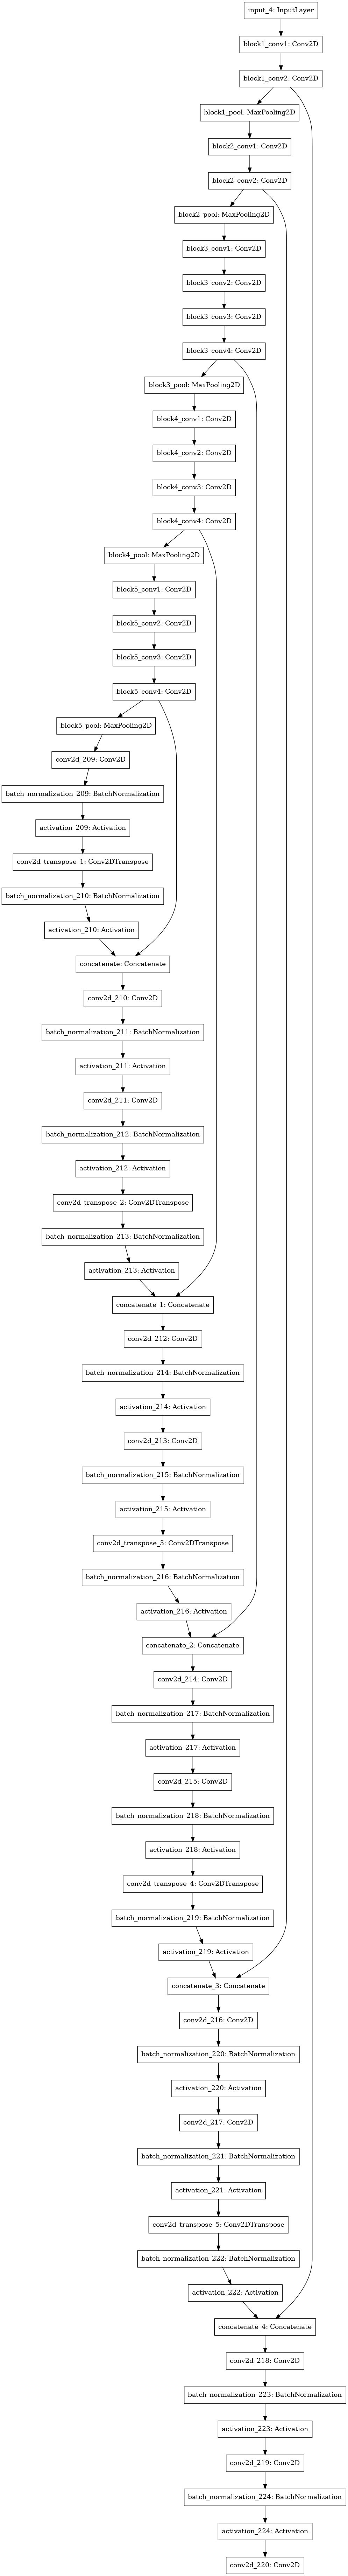

In [31]:
plot_model(model, to_file='model.png')

In [6]:
# Возьмем побольше примеров
COCO_train_ds = COCO_Dataset('train', max_samples=10000)
COCO_val_ds = COCO_Dataset('val', max_samples=10000)

loading annotations into memory...
Done (t=11.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [7]:
train_ds = COCO_train_ds.train_dataset(batch_size=32, inp_size=256)
val_ds = COCO_val_ds.val_dataset(batch_size=32, inp_size=256)

In [34]:
# И попробуем по-учить...

In [35]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
312/312 [==============================] - 265s 801ms/step - loss: 0.3486 - dice_coef: 0.5463 - val_loss: 1.7327 - val_dice_coef: 0.6098
Epoch 2/10
312/312 [==============================] - 274s 877ms/step - loss: 0.2576 - dice_coef: 0.6436 - val_loss: 0.2949 - val_dice_coef: 0.7276
Epoch 3/10
312/312 [==============================] - 270s 863ms/step - loss: 0.2499 - dice_coef: 0.6594 - val_loss: 0.2722 - val_dice_coef: 0.6342
Epoch 4/10
312/312 [==============================] - 274s 879ms/step - loss: 0.2388 - dice_coef: 0.6729 - val_loss: 0.5432 - val_dice_coef: 0.6816
Epoch 5/10
312/312 [==============================] - 274s 878ms/step - loss: 0.2393 - dice_coef: 0.6725 - val_loss: 0.4843 - val_dice_coef: 0.6819
Epoch 6/10
312/312 [==============================] - 249s 798ms/step - loss: 0.2309 - dice_coef: 0.6876 - val_loss: 0.2333 - val_dice_coef: 0.6533
Epoch 7/10
312/312 [==============================] - 234s 749ms/step - loss: 0.2242 - dice_coef: 0.6927 - val_l

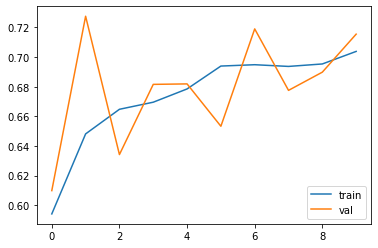

In [36]:
plt.plot(range(10), history.history['dice_coef'])
plt.plot(range(10), history.history['val_dice_coef'])
plt.legend(('train', 'val'))

In [37]:
# Не супер результативно, но какой-то скор есть...

In [8]:
test_batch = iter(val_ds).next()

In [39]:
test_img = test_batch[0][0].numpy()

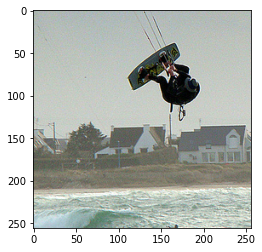

In [40]:
plt.imshow(test_img)

In [41]:
preds = model.predict(test_img[None, ...])

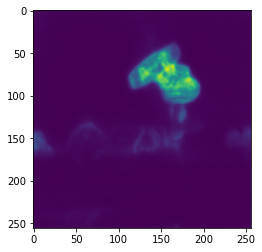

In [45]:
plt.imshow(preds[0])

In [46]:
# Нуу... такое..
# Можно порог попытаться подобрать....

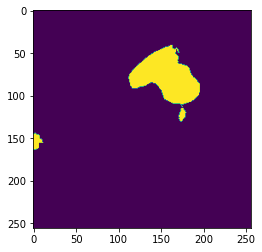

In [55]:
plt.imshow(preds[0]>0.075)

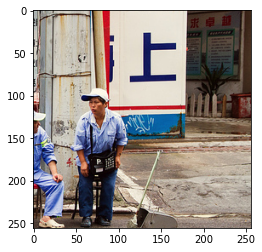

In [60]:
test_img = test_batch[0][6].numpy()
plt.imshow(test_img)

In [61]:
preds = model.predict(test_img[None, ...])

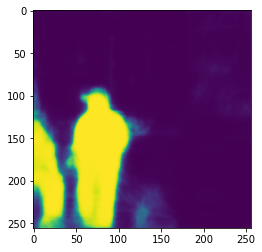

In [62]:
plt.imshow(preds[0])

In [63]:
# Вобщем местами даже как-то работает )

In [64]:
# Можно попробовать разморозить веса VGG и потренировать дальше...

In [65]:
for layer in model.layers:
    if 'batch_normalization' not in layer.name:
        layer.trainable = True

In [66]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [67]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])

In [68]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
312/312 [==============================] - 342s 1s/step - loss: 0.2442 - dice_coef: 0.6752 - val_loss: 0.2024 - val_dice_coef: 0.7183
Epoch 2/10
312/312 [==============================] - 299s 957ms/step - loss: 0.2089 - dice_coef: 0.7232 - val_loss: 0.1950 - val_dice_coef: 0.7326
Epoch 3/10
312/312 [==============================] - 300s 959ms/step - loss: 0.1925 - dice_coef: 0.7372 - val_loss: 0.1911 - val_dice_coef: 0.7390
Epoch 4/10
312/312 [==============================] - 297s 951ms/step - loss: 0.1850 - dice_coef: 0.7457 - val_loss: 0.2143 - val_dice_coef: 0.6927
Epoch 5/10
312/312 [==============================] - 296s 948ms/step - loss: 0.1808 - dice_coef: 0.7547 - val_loss: 0.2287 - val_dice_coef: 0.6834
Epoch 6/10
312/312 [==============================] - 295s 943ms/step - loss: 0.1792 - dice_coef: 0.7595 - val_loss: 0.2305 - val_dice_coef: 0.6998
Epoch 7/10
312/312 [==============================] - 296s 948ms/step - loss: 0.1784 - dice_coef: 0.7576 - val_loss

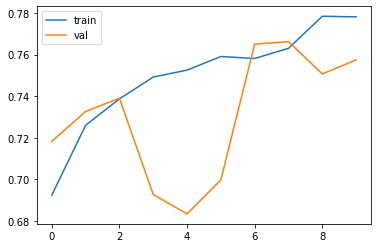

In [69]:
plt.plot(range(10), history.history['dice_coef'])
plt.plot(range(10), history.history['val_dice_coef'])
plt.legend(('train', 'val'))

In [70]:
# Немного выше получилось зайти...

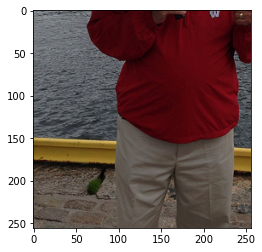

In [77]:
test_img = test_batch[0][11].numpy()
plt.imshow(test_img)

In [78]:
preds = model.predict(test_img[None, ...])

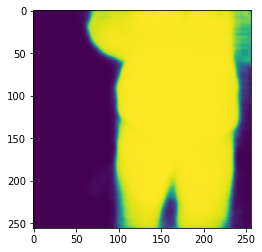

In [79]:
plt.imshow(preds[0])

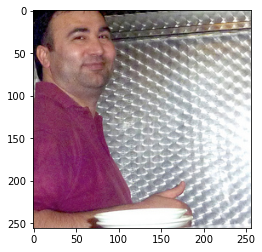

In [80]:
test_img = test_batch[0][12].numpy()
plt.imshow(test_img)

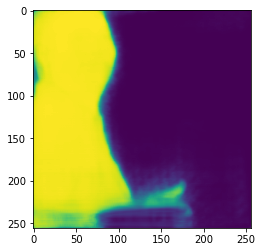

In [81]:
preds = model.predict(test_img[None, ...])
plt.imshow(preds[0])

In [82]:
# Нормал

In [83]:
# Еще хотелось ASPPNET попробовать.. U-Net-то мы уже делали на вводном курсе по нейронкам..

In [9]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = Conv2D(256, (1, 1), padding='same', activation='relu')
        
    def call(self, x, is_training=False):
        out1 = self.conv1(x)
        out2 = self.conv2(x)
        out3 = self.conv3(x)
        out4 = self.conv4(x)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out

In [10]:
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = Conv2D(512, (3, 3), padding='same', activation='relu')
        
        self.conv11 = Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = Conv2D(1, (1, 1), padding='same', activation=None)
        
        self.maxpool = MaxPooling2D((2, 2), (2, 2), padding='same')
        
        self.aspp = ASPPBlock()
    
    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)
        
        out = self.aspp(out)
        
        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BICUBIC)
        
        out_enc_mid = self.conv11(out_enc_mid)
        
        out = tf.concat([out, out_enc_mid], axis=3)
        
        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)
        
        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BICUBIC)
        out = tf.nn.sigmoid(out)
        return out
    

In [29]:
model = ASPPNet()

In [30]:
base_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate)
loss = tf.keras.losses.BinaryCrossentropy()

In [31]:
from itertools import cycle
val_cycle = cycle(val_ds)
losses = {'train': [], 'val': []}
for epoch in range(3):
    print(f'{epoch=}')
    
    for iteration, (images, labels) in enumerate(train_ds):
        # Forward
        with tf.GradientTape() as tape:
            logits = model(images)
            loss_value = loss(logits, labels)

        # Backward
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Calc and display loss
        if iteration % 50 == 0:
            val_images, val_labels = next(val_cycle)
            val_logits = model(val_images)
            val_loss = loss(val_logits, val_labels)
            losses['val'].append(np.average(val_loss))
            losses['train'].append(np.average(loss_value))
            print(f'{iteration} Train Loss: {np.average(loss_value)}, Val Loss: {np.average(val_loss)}')

epoch=0
0 Train Loss: 7.70134973526001, Val Loss: 3.390411138534546
50 Train Loss: 3.2309770584106445, Val Loss: 3.0796589851379395
100 Train Loss: 3.2214207649230957, Val Loss: 3.6309866905212402
150 Train Loss: 3.1004087924957275, Val Loss: 3.93233585357666
200 Train Loss: 2.6513609886169434, Val Loss: 2.8773655891418457
250 Train Loss: 3.191678047180176, Val Loss: 3.0689258575439453
300 Train Loss: 2.8404572010040283, Val Loss: 2.5415358543395996
epoch=1
0 Train Loss: 2.9634504318237305, Val Loss: 3.9432811737060547
50 Train Loss: 3.705746650695801, Val Loss: 3.897036075592041
100 Train Loss: 3.919189691543579, Val Loss: 2.9196770191192627
150 Train Loss: 3.466625213623047, Val Loss: 3.4621870517730713
200 Train Loss: 3.474945545196533, Val Loss: 2.7067670822143555
250 Train Loss: 3.445955753326416, Val Loss: 3.3376147747039795
300 Train Loss: 2.9425323009490967, Val Loss: 2.3596997261047363
epoch=2
0 Train Loss: 3.617826223373413, Val Loss: 4.505751132965088
50 Train Loss: 2.760725

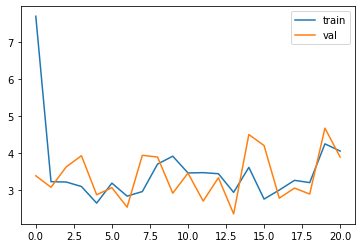

In [32]:
plt.plot(range(21), losses['train'])
plt.plot(range(21), losses['val'])
plt.legend(('train', 'val'))

In [110]:
# Ну, как-то не сильно здорово она учится..
# Либо я что-то не то делаю совсем, либо модель хуже предыдущей..

In [130]:
# Для очистки совести попробовать посмотреть - чему научилось..

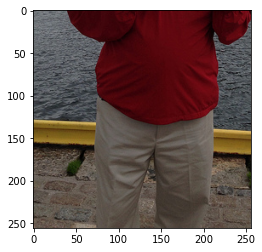

In [24]:
test_img = test_batch[0][11].numpy()
plt.imshow(test_img)

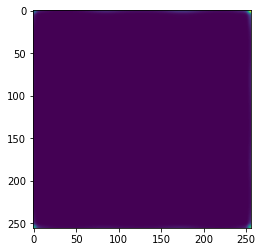

In [25]:
preds = model.predict(test_img[None, ...])
plt.imshow(preds[0])

In [28]:
# Что-то вообще ничего... (